## Clasificacion de las imagenes

In [ ]:
import os
import glob
import datetime
import tarfile
import urllib.request

train_dir = "dataset"

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# get the class label limit
class_limit = 70

# take all the images from the dataset
image_paths = glob.glob(train_dir + "\\train\\*.png")

# variables to keep track
label = 0
i = 0
j = 16

# flower17 class names
class_names = ['apple', 'bat', 'beetle', 'bell', 'bird', 'Bone', 'bottle', 'brick', 
               'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', 
               'chicken', 'children', 'chopper', 'classic', 'Comma', 'crown', 'cup', 
               'deer', 'device0', 'device1', 'device2', 'device3', 'device4', 'device5', 
               'device6', 'device7', 'device8', 'device9', 'dog', 'elephant', 'face', 
               'fish', 'flatfish', 'fly', 'fork', 'fountain', 'frog', 'Glas', 'guitar', 
               'hammer', 'hat', 'HCircle', 'Heart', 'horse', 'horseshoe', 'jar', 'key', 
               'lizzard', 'lmfish', 'Misk', 'octopus', 'pencil', 'personal_car', 'pocket', 
               'rat', 'ray', 'sea_snake', 'shoe', 'spoon', 'spring', 'stef', 'teddy', 'tree', 
               'truck', 'turtle', 'watch']

# loop over the class labels
for x in range(1, class_limit+1):
    # create a folder for that class
    os.makedirs(train_dir + "\\train\\" + class_names[label])

    # get the current path
    cur_path = train_dir + "\\train\\" + class_names[label] + "\\"

    # loop over the images in the dataset
    for index, image_path in enumerate(image_paths[i:j], start=1):
        original_path   = image_path
        image_path      = image_path.split("\\")
        image_file_name = str(index) + ".png"
        os.rename(original_path, cur_path + image_file_name)

    i += 16
    j += 16
    label += 1

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py


images_per_class = 16
fixed_size = tuple((500, 500))
train_path = "dataset/train"
h5_data = 'output/data.h5'
h5_labels = 'output/labels.h5'
bins = 8

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".png"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

['Bone', 'Comma', 'Glas', 'HCircle', 'Heart', 'Misk', 'apple', 'bat', 'beetle', 'bell', 'bird', 'bottle', 'brick', 'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', 'chicken', 'children', 'chopper', 'classic', 'crown', 'cup', 'deer', 'device0', 'device1', 'device2', 'device3', 'device4', 'device5', 'device6', 'device7', 'device8', 'device9', 'dog', 'elephant', 'face', 'fish', 'flatfish', 'fly', 'fork', 'fountain', 'frog', 'guitar', 'hammer', 'hat', 'horse', 'horseshoe', 'jar', 'key', 'lizzard', 'lmfish', 'octopus', 'pencil', 'personal_car', 'pocket', 'rat', 'ray', 'sea_snake', 'shoe', 'spoon', 'spring', 'stef', 'teddy', 'tree', 'truck', 'turtle', 'watch']
[STATUS] processed folder: Bone
[STATUS] processed folder: Comma
[STATUS] processed folder: Glas
[STATUS] processed folder: HCircle
[STATUS] processed folder: Heart
[STATUS] processed folder: Misk
[STATUS] processed folder: apple
[STATUS] processed folder: bat
[STATUS] processed folder: beetle
[STATUS] processed fol

In [2]:
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

num_trees = 1000
test_size = 0.80
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')



global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)
print(len(global_labels))

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\sanix\Anaconda3\envs\ia2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1120
[STATUS] features shape: (1120, 532)
[STATUS] labels shape: (1120,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (224, 532)
Test data   : (896, 532)
Train labels: (224,)
Test labels : (896,)
LR: 0.044664 (0.028147)
LDA: 0.442490 (0.106780)
KNN: 0.268775 (0.087436)
CART: 0.367194 (0.101184)
RF: 0.549012 (0.097592)
NB: 0.312451 (0.085079)
SVM: 0.000000 (0.000000)


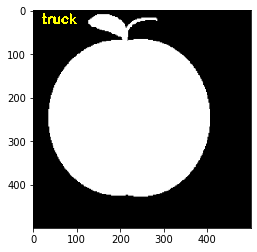

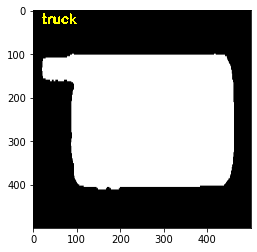

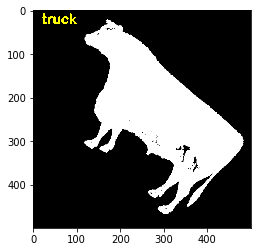

67


In [3]:
import matplotlib.pyplot as plt

#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 16

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.png"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    global_feature = np.reshape(global_feature, (-1, 2))
    rescaled_feature = scaler.fit_transform(global_feature)

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
print(prediction)